In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler,QuantileTransformer
from sklearn.cross_validation import StratifiedKFold,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,GridSearchCV,cross_val_predict
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectFromModel,SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import cross_validation, feature_selection, pipeline,preprocessing, linear_model, grid_search
from sklearn import decomposition
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import warnings
import os

%matplotlib inline

Install imbalanced learn using below on command prompt ( with Anaconda installed):
    conda install -c glemaitre imbalanced-learn
    Alternatively, follow the steps here:
    http://pandas-ml.readthedocs.io/en/latest/imbalance.html 

Read the data starting with row 2 (based on obervation in bash prompt)

In [82]:
def read_data():
    #Function to read data from row 2 as header and onwards
    data = pd.read_csv('LendingClub2012to2013.csv',header=1,low_memory=False)
    return data


In [83]:
def transform_loan_status(x):
    #Function To Transofrm loan status to binary classification problem
    status = 0
    if x in ['Fully Paid','In Grace Period']:
        #Current status does not provide any useful information
        status = 0
        return status # Indicating Acceptable status
    elif x in ['Late (16-30 days)','Default','Late (31-120 days)','Charged Off']:
        status = 1
        return status
    return np.nan


In [84]:
def check_redundancy(model_categorical,model_continuous):
    status =0
    for x in model_continuous:
        if x in model_categorical:
            status =1
            print(x,' is in model_categorical too')
    for x in model_categorical:
        if x in model_continuous:
            status =1
            print(x,' is in model_continuous too')
    if status == 0:
        print('No Duplicate features')

        

In [85]:
def clean_features(df):
    df['int_rate'] = df['int_rate'].apply(lambda x: x.replace('%',''))
    df['int_rate'] = df['int_rate'].apply(pd.to_numeric)
    df['revol_util'] =df['revol_util'].astype(str).apply(lambda x: x.replace('%','')).replace('nan','')
    df['revol_util'] =df['revol_util'].apply(pd.to_numeric)
    df['emp_length'] = df['emp_length'].apply(lambda x: x.split()[0].replace('+','').replace('<','').replace('<','').replace('n/a',''))
    df['emp_length'] =df['emp_length'].apply(pd.to_numeric)

In [86]:
def drop_non_useful_columns(data,model_continuous,model_categorical):
    data.application_type.value_counts() # dropping the column
    data.emp_title.nunique() # Too many unique values dropping the column
    data.initial_list_status.value_counts() 
    data.pymnt_plan.value_counts()  # dropping the column
    print('application_type : dropping the column: No useful information')
    print('pymnt_plan : dropping the column: No useful information')
    print('emp_title : dropping the column: Too many unique values dropping the column')
    model_categorical.remove('application_type')
    model_categorical.remove('pymnt_plan')
    model_categorical.remove('emp_title')

    #Unlist the features with more than 50% mising values from feature selection
    print('Unlisted Below features with more than 50% mising values from feature selection')
    for x in data[model_continuous].columns:
        if (data[x].count()/len(data)) <0.5:
            print(x)
            model_continuous.remove(x)
    for x in data[model_categorical].columns:
        if (data[x].count()/len(data)) <0.5:
            print(x)
            model_categorical.remove(x)


In [87]:
def check_leakage():
    status =0
    leakage = ['int_rate','issue_d', 'recoveries', 'collection_recovery_fee', 'last_fico_range_high', 'last_fico_range_low', 'last_credit_pull_d', 'total_rec_prncp', 'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_d', 'total_rec_late_fee', 'total_rec_int', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'out_prncp', 'out_prncp_inv', 'pymnt_plan', 'next_pymnt_d']
    for x in hybrid:
        if x in leakage:
            print('Leakage column selected! : ',x)
            status =1
    if status == 0:
        print('No leakage columns in selection')

In [88]:
def impute_missing(data):
    data_imputed = data[hybrid]
    data_imputed[model_categorical] = data[model_categorical].apply(lambda x:x.fillna(x.value_counts().index[0]))
    data_imputed[model_continuous] = data[model_continuous].apply(lambda x:x.fillna(x.mean()))
    if max(pd.isnull(data_imputed[hybrid]).any(axis=1)) == False:
        print('Data Imputedation complete. There are no missing values in returned dataframe')
    return data_imputed


In [89]:
def dummy_code_and_drop_correlated_features(data_imputed,model_continuous,model_categorical):
    #Convert Categorical Variables into dummy variables and drop highly correlated variables
    data_with_dummies = pd.get_dummies(data_imputed,columns=model_categorical)
    cor = data_with_dummies.corr()
    cor.loc[:,:] = np.tril(cor, k=-1) 
    cor = cor.stack()
    print('Below are the correlated features:')
    print(cor[(cor > 0.645) | (cor < -0.645)])
    dropped_continuous_correlated = ['funded_amnt','funded_amnt_inv','installment','num_sats','initial_list_status_w','term_ 60 months'] 
    
    model_continuous.remove('funded_amnt')
    model_continuous.remove('funded_amnt_inv')
    model_continuous.remove('installment')
    model_continuous.remove('num_sats')
#     model_continuous.remove('initial_list_status_w')
  #  model_continuous.remove('term_ 60 months')
    model_continuous =  [x for x in model_continuous if x not in dropped_continuous_correlated]
    #Drop the Highly correlated variables
    print('Dropped Highly correlated redundant features: ',dropped_continuous_correlated)
    data_with_dummies.drop(dropped_continuous_correlated,inplace=True,axis=1)
    return data_with_dummies


In [90]:
def scale_data(X_train,X_test,model_continuous):
    scaler = StandardScaler()
    X_train[model_continuous] =scaler.fit_transform(X_train[model_continuous])
    X_test[model_continuous] =scaler.transform(X_test[model_continuous])
    return X_train,X_test

In [91]:
def split_test_and_smote(data_with_dummies):
    y = data_with_dummies['loan_status']
    X = data_with_dummies.drop('loan_status',axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    print("Before we proceed further, let's split' the 25% data as test set and use SMOTE to balance the dependent variable.")
    print('It Appears that Our dependent variable is imbalanced.We are using Imbalanced learn package to use SMOTE algorithm in order to handle oversampling for unacceptable loan status data points')
    sm = SMOTE(random_state=12, ratio = 1.0)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    y_train = pd.DataFrame(y_train_res,columns=['loan_status'])
    X_train = pd.DataFrame(X_train_res, columns=X_train.columns)
    return X_train, X_test, y_train, y_test
    

In [92]:
def print_classification_report(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test,y_pred)
    print(report)

In [93]:
def plot_categorial_bivariate(data,model_categorical,only_bad_loans=0):
    data_vis = data
    if only_bad_loans == 1:
        data_vis = data[data.loan_status == 1]
        
    for x in model_categorical:
        if data_vis[x].nunique() >5:
            plt.figure(figsize=(20,4), dpi=700)
        sns.countplot(data_vis[x],hue=data_vis.loan_status)
        plt.savefig('categorical\\' + x)
        plt.show()
        plt.clf()
        

In [94]:
def process_pca(X_train,X_test,components=5):
    pca = decomposition.PCA(n_components=components)
    X_train_full = X_train
    X_test_full = X_test
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    return X_train_full,X_test_full,X_train,X_test

In [95]:
def plot_continuous_univariate(data,model_continuous):
    for x in model_continuous:
        sns.distplot(data[x])
        plt.savefig('continuous_univariate\\' + x)
        plt.show()
        plt.clf()

In [96]:
#Read the data
data =read_data()

Exploring categories and counts in our dependent variable 'loan status'

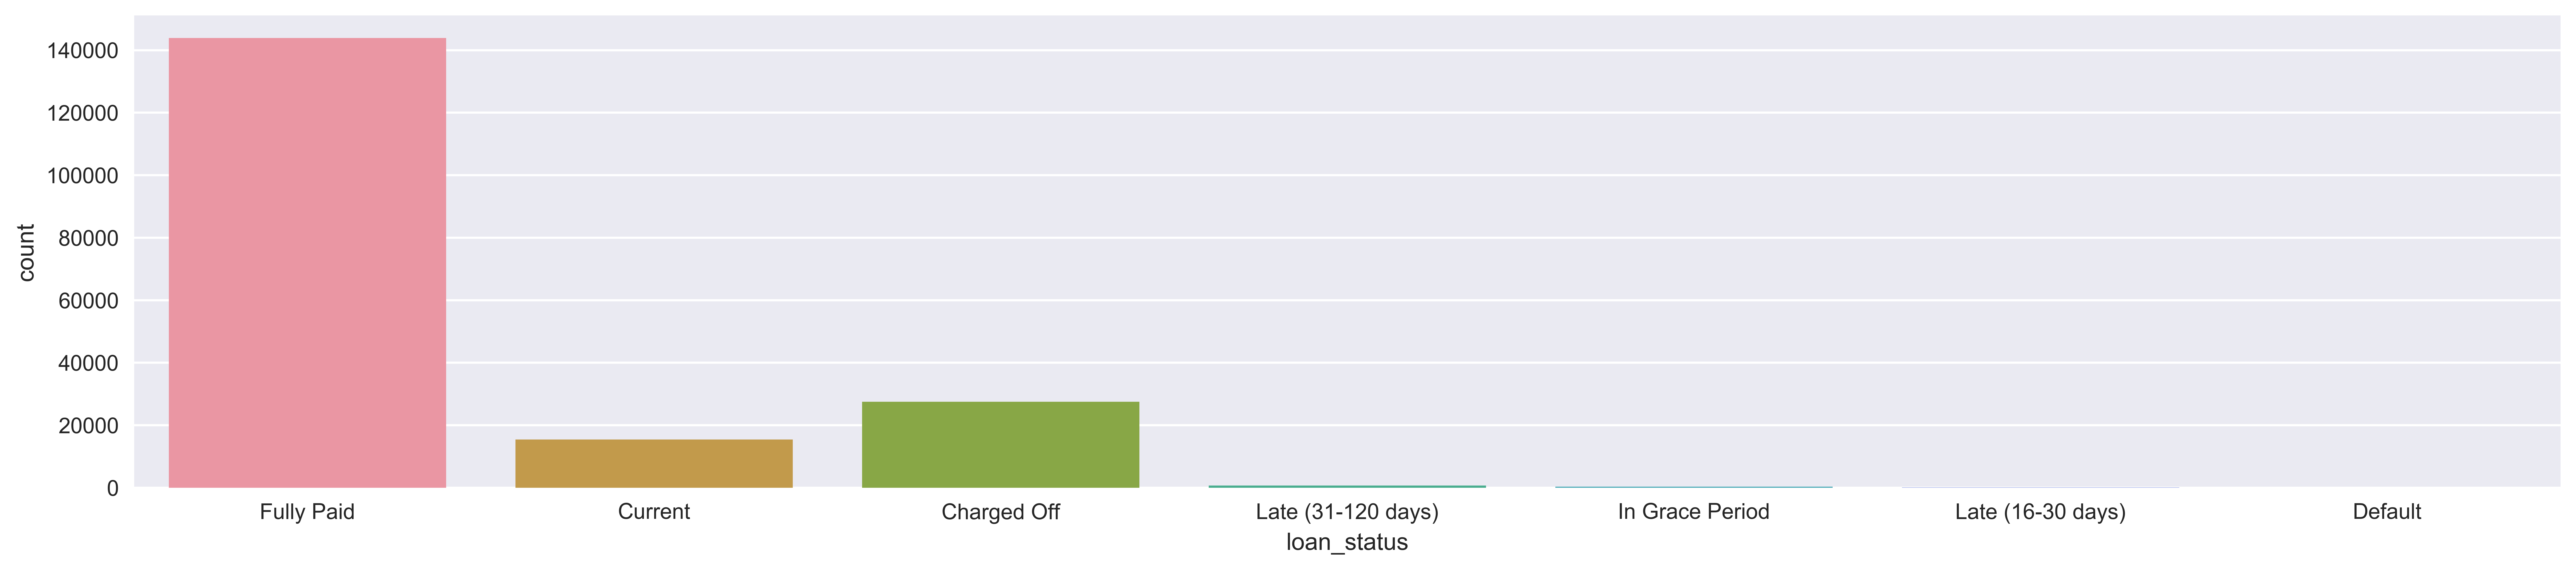

In [97]:
plt.figure(figsize=(20,4), dpi=700)
sns.countplot(x="loan_status", data=data)

As we can see, the Fully paid loans are highest in count - We can combine late payments and charged off/defaults into a single category for better analysis as it and to reduced the scewness in our dependent variable 'loan_status'

In [98]:
data['loan_status']=data['loan_status'].apply(lambda x: transform_loan_status(x))

In [99]:
#Drop the missing values in Dependent Variable
data.dropna(subset = ['loan_status'],inplace=True)

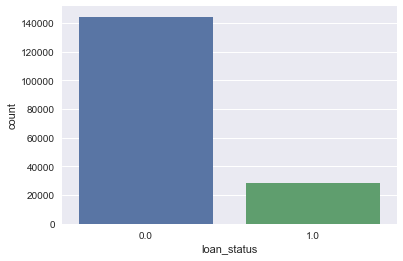

In [100]:

sns.countplot(x='loan_status',data = data)

# Select Features - Initial Selection:
These features are selected based on Business significance and not purely statistical one as this is considered a best practice : Whenever we have enough information about problem domain, it should be the first filter in feature selection unless we have a really good reason for not doing so.
We are creating separate lists for categorical and continuous features as they wil be analyzed/processed Separately 

In [101]:
model_continuous = list(set(['annual_inc','acc_now_delinq','annual_inc_joint','bc_util'
 ,'chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs'
 ,'delinq_amnt','dti','dti_joint','emp_length','fico_range_low','funded_amnt'
 ,'funded_amnt_inv','installment','loan_amnt','mort_acc'
 ,'mths_since_last_delinq','mths_since_recent_bc_dlq','num_accts_ever_120_pd'
 ,'num_bc_sats','num_sats','num_tl_90g_dpd_24m','open_acc','pct_tl_nvr_dlq','percent_bc_gt_75'
 ,'pub_rec','pub_rec_bankruptcies','revol_util','avg_cur_bal','total_acc','total_cu_tl','inq_last_6mths']))

In [102]:
model_categorical = list(set(['addr_state','application_type','grade','emp_title',
                   'home_ownership', 'initial_list_status','pymnt_plan','term', 'purpose',  'verification_status','verification_status_joint']))

Check that features are not repeated in two lists:

In [103]:
check_redundancy(model_categorical,model_continuous)
        

No Duplicate features


In [104]:
clean_features(data)

In [105]:
drop_non_useful_columns(data,model_continuous,model_categorical)

application_type : dropping the column: No useful information
pymnt_plan : dropping the column: No useful information
emp_title : dropping the column: Too many unique values dropping the column
Unlisted Below features with more than 50% mising values from feature selection
mths_since_recent_bc_dlq
dti_joint
total_cu_tl
mths_since_last_delinq
annual_inc_joint
verification_status_joint


As sklearn.preprocessing package's 
imputer method cannot effective handle categorical data m we are using below trick 
to impute missing category with most frequent category:

In [106]:
hybrid = ['loan_status'] + model_continuous+model_categorical

In [107]:
check_leakage() # Check that there are no leakage features in the 

No leakage columns in selection


In [108]:
data_imputed = impute_missing(data[hybrid])

Data Imputedation complete. There are no missing values in returned dataframe


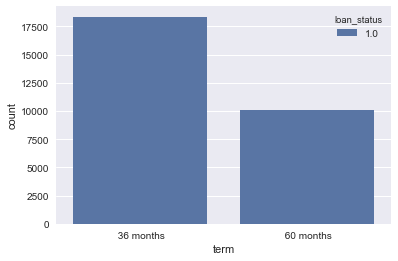

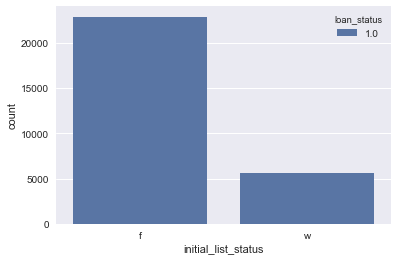

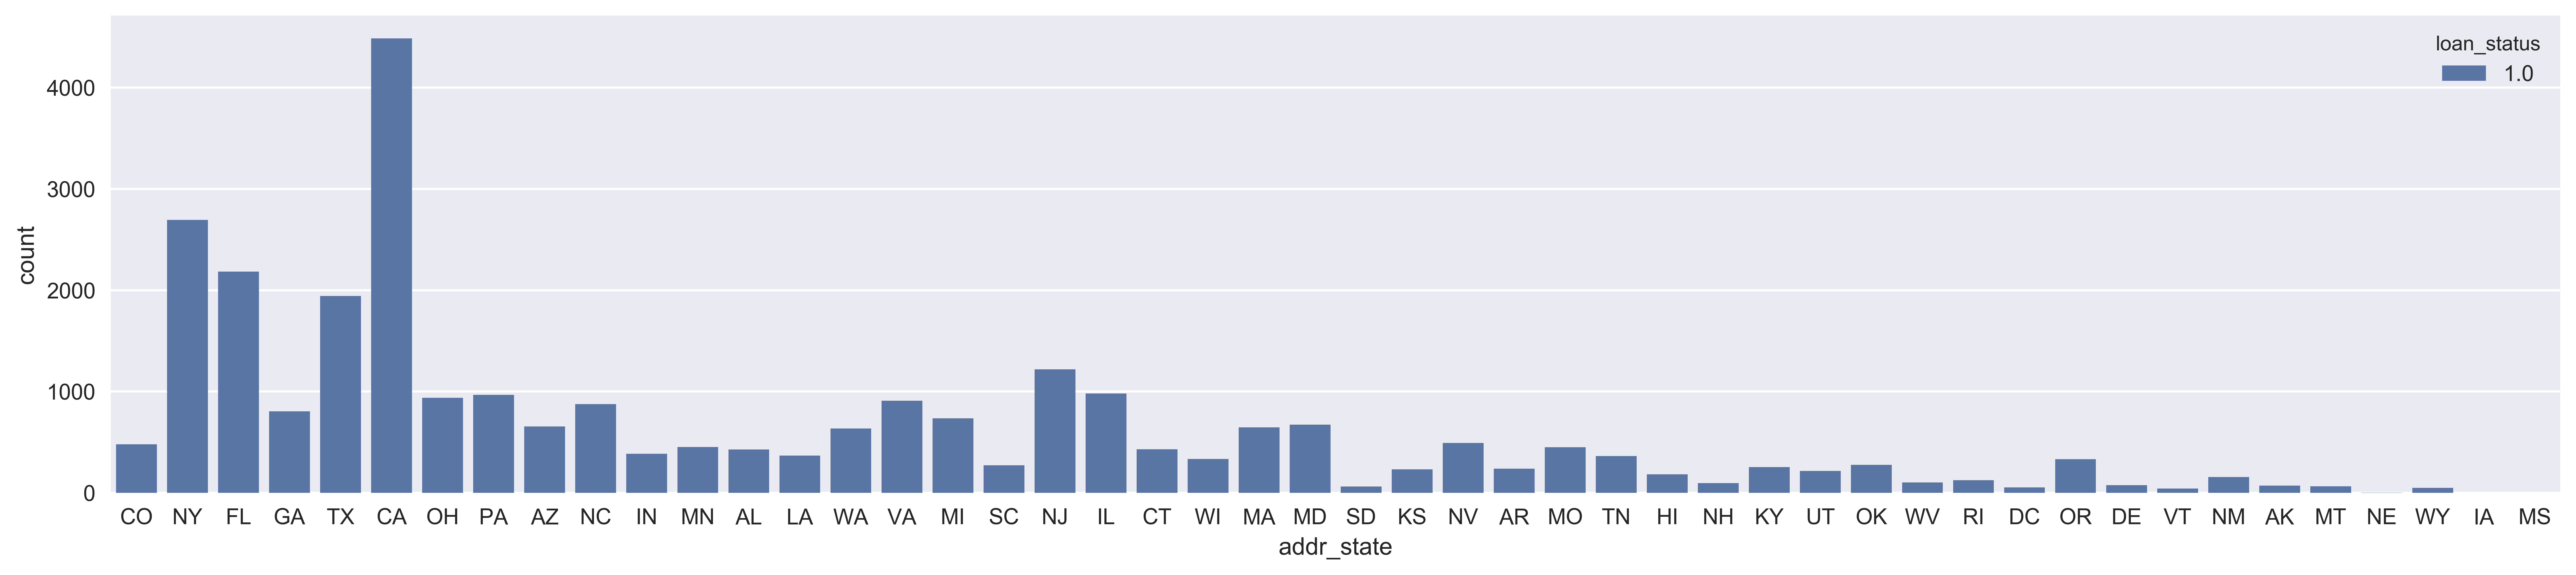

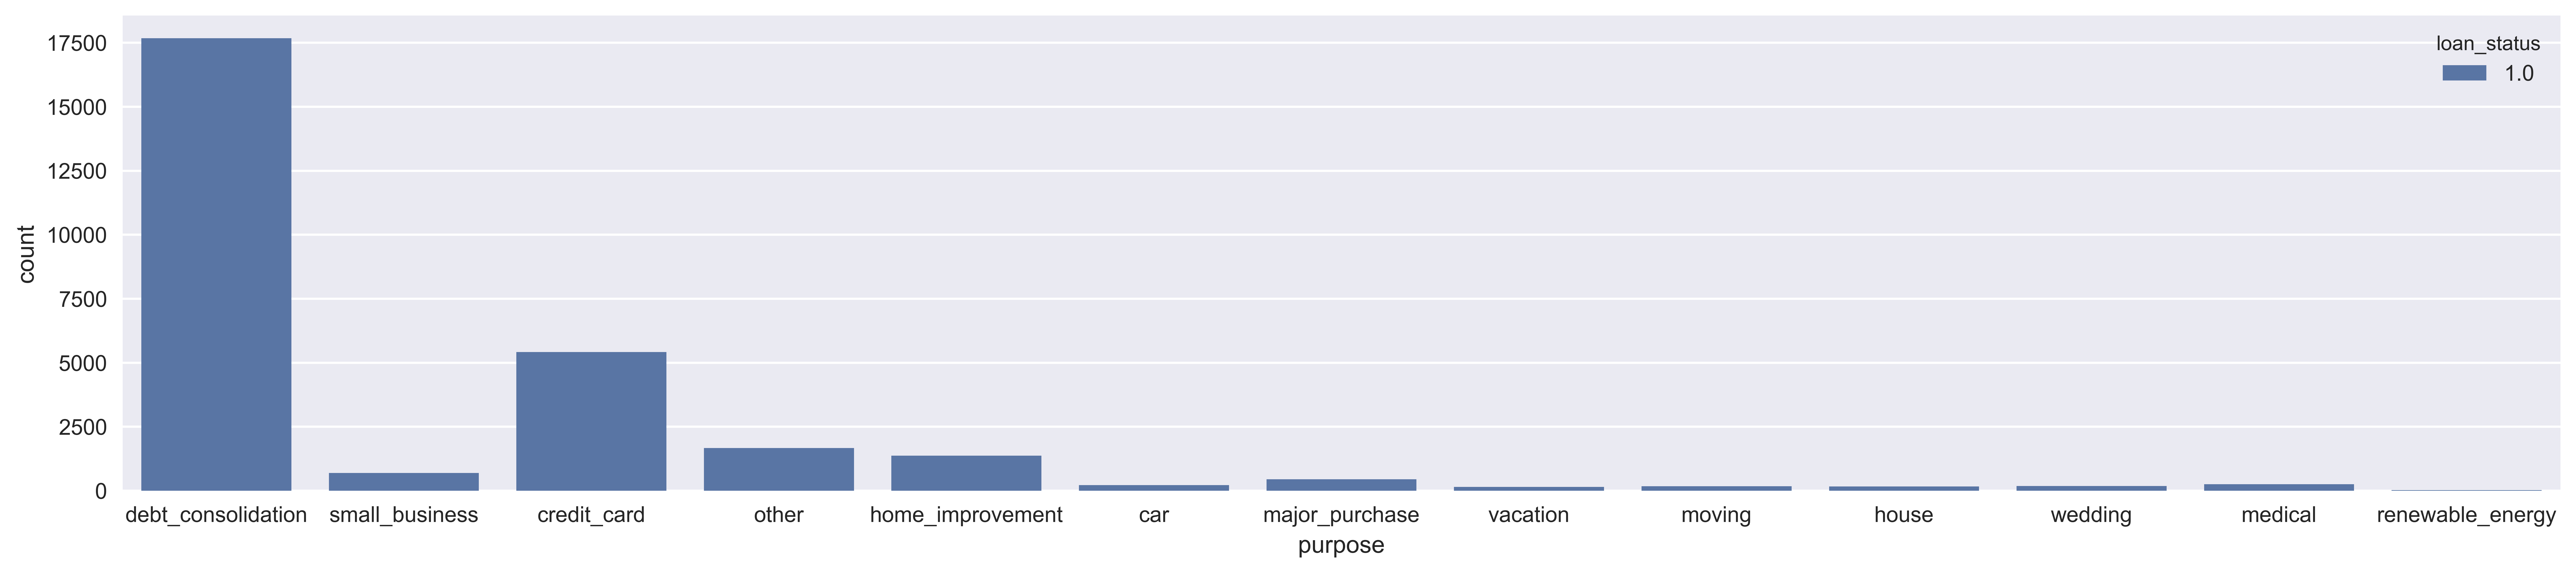

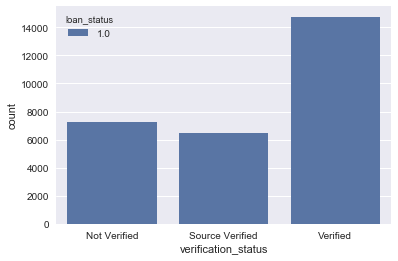

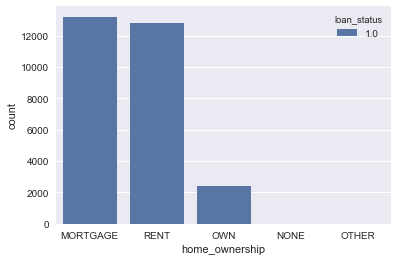

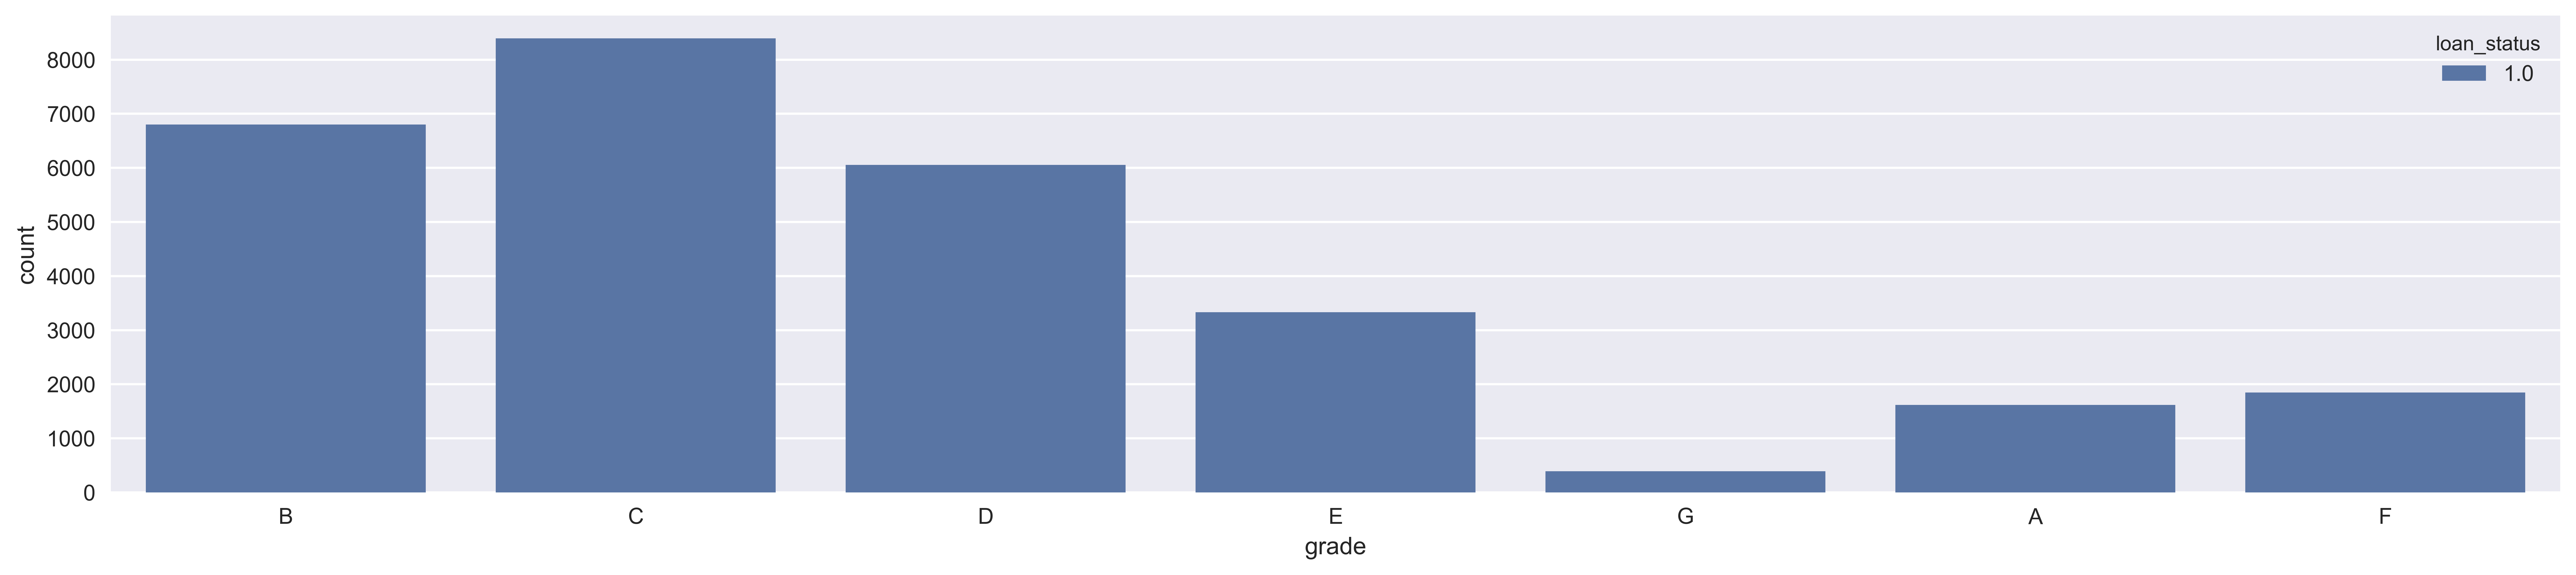

In [109]:
plot_categorial_bivariate(data_imputed,model_categorical,only_bad_loans=1)

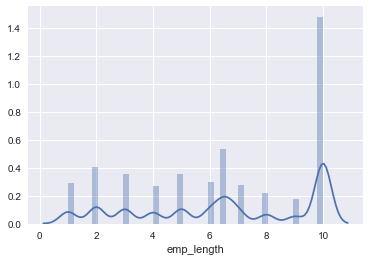

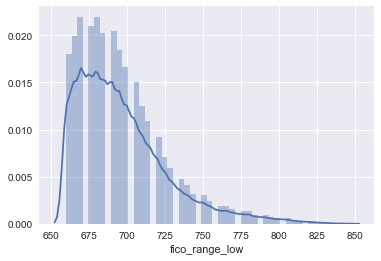

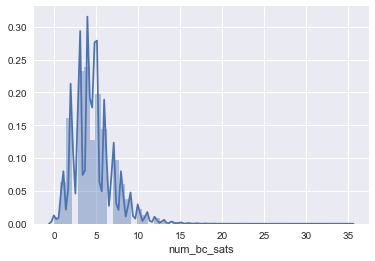

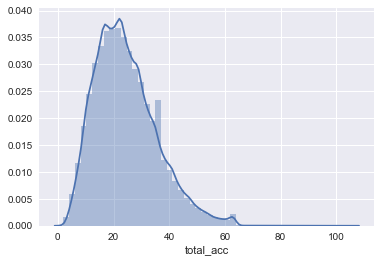

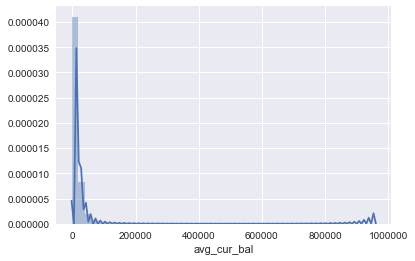

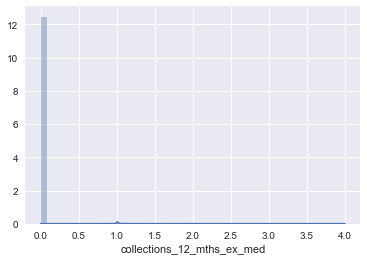

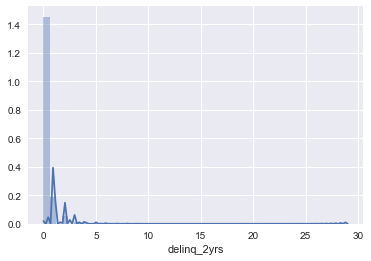

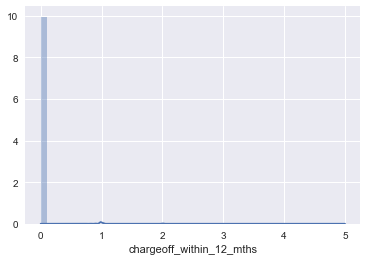

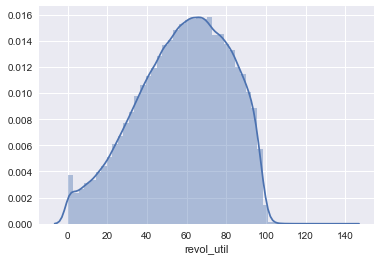

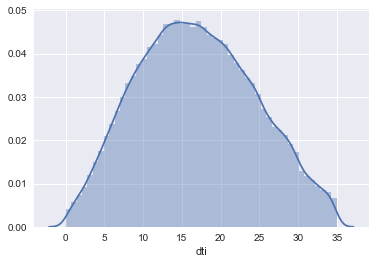

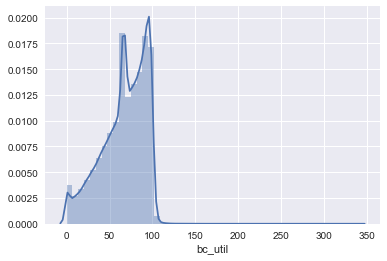

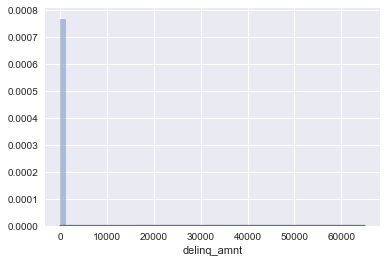

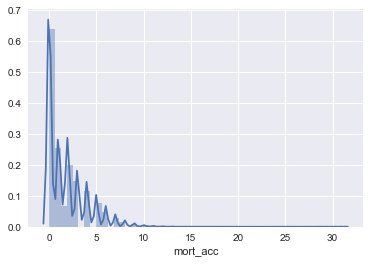

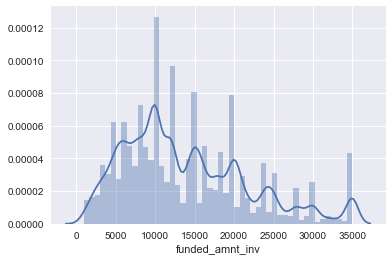

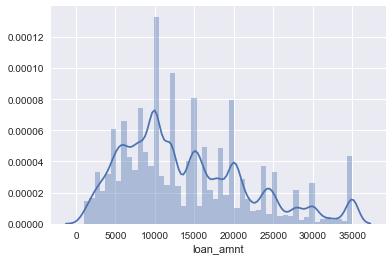

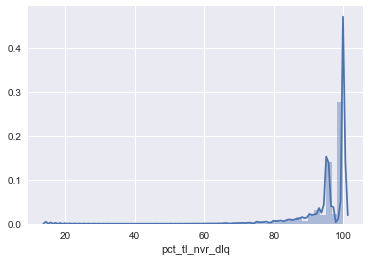

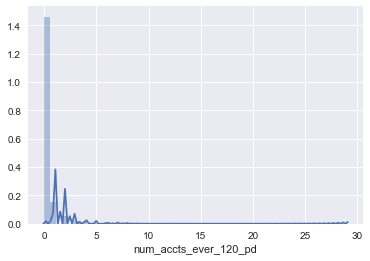

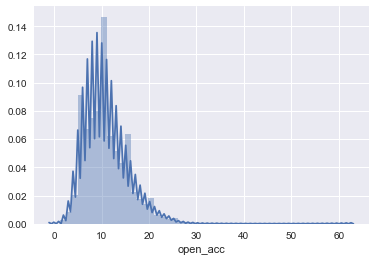

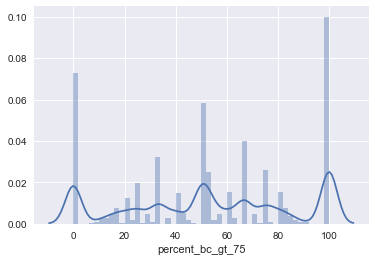

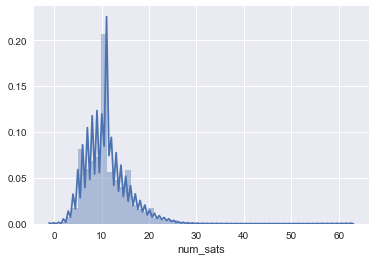

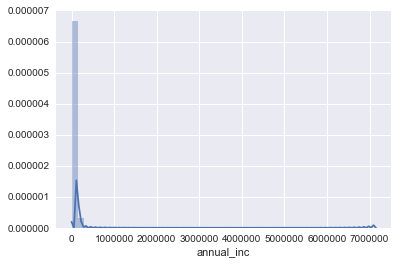

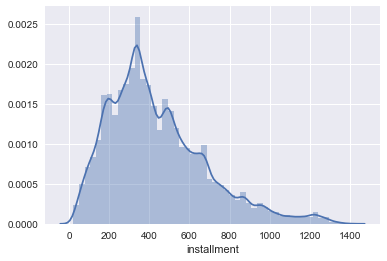

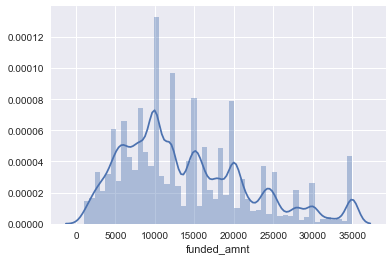

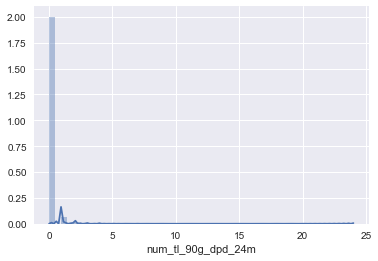

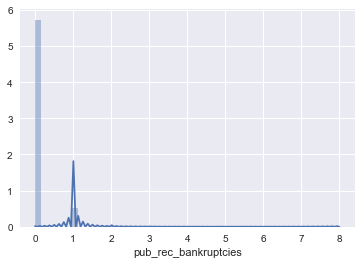

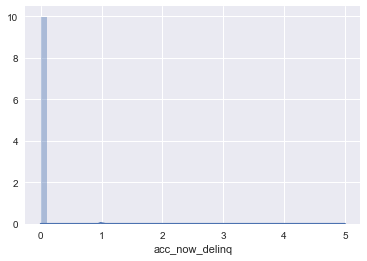

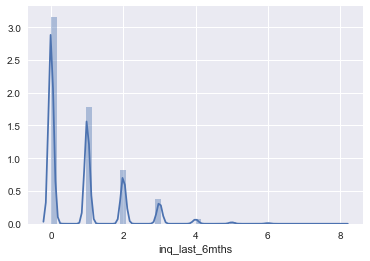

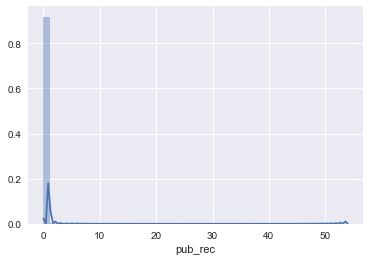

In [110]:
plot_continuous_univariate(data_imputed,model_continuous)

Convert Categorical Variables into dummy variables and drop highly correlated variables

In [111]:
 data_with_dummies =  dummy_code_and_drop_correlated_features(data_imputed,model_continuous,model_categorical)

Below are the correlated features:
bc_util                     revol_util                 0.811591
loan_amnt                   funded_amnt_inv            0.999633
open_acc                    total_acc                  0.664996
percent_bc_gt_75            revol_util                 0.681635
                            bc_util                    0.831405
num_sats                    open_acc                   0.958030
installment                 funded_amnt_inv            0.963026
                            loan_amnt                  0.962806
funded_amnt                 funded_amnt_inv            0.999859
                            loan_amnt                  0.999785
                            installment                0.963079
pub_rec                     pub_rec_bankruptcies       0.758693
term_ 60 months             term_ 36 months           -1.000000
initial_list_status_w       initial_list_status_f     -1.000000
purpose_debt_consolidation  purpose_credit_card       -0.653543
home_

Before we proceed further, let's split' the 25% data as test set and use SMOTE to balance the dependent variable.

It Appears that Our dependent variable is imbalanced

We are using Imbalanced learn package to use SMOTE algorithm in order to handle 
oversampling for unacceptable loan status data points

In [112]:
# Keep 25% data as Test data and perform oversampling to balance the loan_status using SMOTE
X_train, X_test, y_train, y_test = split_test_and_smote(data_with_dummies)


Before we proceed further, let's split' the 25% data as test set and use SMOTE to balance the dependent variable.
It Appears that Our dependent variable is imbalanced.We are using Imbalanced learn package to use SMOTE algorithm in order to handle oversampling for unacceptable loan status data points


# Explore K Best Features

Change the value of K below to play around with different thresholds

In [114]:
from sklearn.feature_selection import SelectKBest

In [115]:
kbest = SelectKBest(k=50)

In [116]:
Xtrain = kbest.fit_transform(X_train,y_train)

In [117]:
mask = kbest.get_support()
new_features = X_train.columns[mask]

In [118]:
new_features

Index(['fico_range_low', 'num_bc_sats', 'total_acc', 'avg_cur_bal',
       'revol_util', 'dti', 'bc_util', 'mort_acc', 'loan_amnt',
       'pct_tl_nvr_dlq', 'open_acc', 'percent_bc_gt_75', 'annual_inc',
       'inq_last_6mths', 'term_ 36 months', 'initial_list_status_f',
       'addr_state_AL', 'addr_state_CA', 'addr_state_CO', 'addr_state_DC',
       'addr_state_FL', 'addr_state_IL', 'addr_state_IN', 'addr_state_LA',
       'addr_state_MT', 'addr_state_NJ', 'addr_state_NY', 'addr_state_SC',
       'addr_state_TN', 'addr_state_TX', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_major_purchase', 'purpose_other', 'purpose_small_business',
       'purpose_wedding', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'home_ownership_MORTGAGE', 'home_ownership_RENT', 'grade_A', 'grade_B',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G'],
 

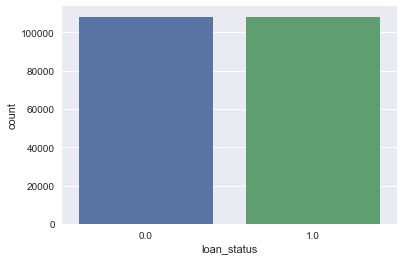

In [119]:
sns.countplot(x=y_train['loan_status'],data = y_train)

# Use StandardScaler to Scale the data
- This is needed as we are using classifiers which are sensitive to the scale of distance measure and it is necessary to have a uniform scale for all the features

In [120]:
X_train,X_test = scale_data(X_train,X_test,model_continuous)

## Use Decision Tree to Explore feature importance

In [125]:
def getTopKDecisionTreeFeatures(X_train,y_train,k):
        
    dt = DecisionTreeClassifier()

    dt.fit(X_train,y_train)

    features = pd.DataFrame(data= list(dt.feature_importances_),index=list(X_train.columns),columns=['importance']).reset_index()

    sorted_features = features.sort_values(by=['importance'],ascending=False)

    return (list(sorted_features['index'])[0:k])

In [126]:
from sklearn.base import BaseEstimator, TransformerMixin
class TopKDecisionTreeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self,k=50):
        self.k = k
        self.dt = DecisionTreeClassifier()
    def fit(self, X_train, y_train):
        self.dt.fit(X_train,y_train)
        self.features = pd.DataFrame(data= list(self.dt.feature_importances_),
                                     index=list(X_train.columns),columns=['importance']).reset_index()
        self.sorted_features = self.features.sort_values(by=['importance'],ascending=False)
        self.topk = list(self.sorted_features['index'])[0:self.k]
        return self
    def transform(self, x):
        return(x[self.topk])

## SELECT K Best Features - find number K

### Below is the list of top  features ( we have selected this number based on putput of SelectKBest pipeline) - Warning - This takes hours to run - Please comment till PCA step to skip it  or Uncomment to run it


In [127]:
# dt_pipeline = make_pipeline(TopKDecisionTreeFeatures(),DecisionTreeClassifier())

In [128]:
# dt_parameters = dict(topkdecisiontreefeatures__k=[40,75,90,103])

In [129]:
# cv = sklearn.model_selection.KFold(n_splits=4)

In [130]:
# dt = GridSearchCV(dt_pipeline, param_grid=dt_parameters, scoring='f1', cv=cv)

In [131]:
# warnings.filterwarnings("ignore")

In [132]:
# dt.fit(X_train,y_train)

In [133]:
# dt.best_estimator_

Best estimator:
Pipeline(memory=None,
     steps=[('topkdecisiontreefeatures', TopKDecisionTreeFeatures(k=40)), ('decisiontreeclassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [134]:
len(list(X_train.columns))

103

GridSearchCV  for RandomForestClassifier takes long time to find optimal model  (more than 8 hours for the 48 features. For this reason, we will use PCA to reduce the number of features to 10 while preserving most of the variance)

# Dimensionality Reduction using PCA
## Below code can be commented to see the performance difference with and without PCA ( Also rerun whole Notebook from the beginning )

In [138]:
X_train_full,X_test_full,X_train,X_test = process_pca(X_train,X_test,components=4)

# Running classifiers using default parameters for Initial judgement:

# Naive Bayes Classifier

In [139]:
nbc = GaussianNB()

In [140]:
print_classification_report(nbc,X_train,y_train,X_test,y_test)

             precision    recall  f1-score   support

        0.0       0.87      0.42      0.57     36034
        1.0       0.19      0.68      0.30      7154

avg / total       0.76      0.46      0.52     43188



# Logistic Regression

In [141]:
lc = LogisticRegression()

In [142]:
print_classification_report(lc,X_train,y_train,X_test,y_test)

             precision    recall  f1-score   support

        0.0       0.87      0.52      0.65     36034
        1.0       0.20      0.61      0.31      7154

avg / total       0.76      0.54      0.60     43188



# DecisionTreeClassifier

In [143]:
dtc = DecisionTreeClassifier()

In [144]:
dtc.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [145]:
print_classification_report(dtc,X_train, y_train, X_test, y_test)

             precision    recall  f1-score   support

        0.0       0.84      0.56      0.67     36034
        1.0       0.18      0.47      0.26      7154

avg / total       0.73      0.55      0.61     43188



# K Nearest Neighbors 

As this is the most processor intensive algorithm out of teh nes we have picked, we will use dimensionality reducted using PCA with just 4 componets in order to increase execution time ( Otherwise it runs for manyhours without output)

In [149]:
knnc = KNeighborsClassifier()

In [150]:
X_train_full,X_test_full,X_train,X_test = process_pca(X_train, X_test, components=4)

In [151]:
print_classification_report(knnc,X_train,y_train,X_test,y_test)

             precision    recall  f1-score   support

        0.0       0.85      0.56      0.67     36034
        1.0       0.18      0.49      0.26      7154

avg / total       0.74      0.55      0.60     43188



In [152]:
#Recover Original dataset Before PCA - Please skip this to run further part in reasonable amount of time
X_train,X_test = X_train_full,X_test_full

# 10-Fold cross validation using GridSearchCV

In [153]:
cv = sklearn.model_selection.KFold(n_splits=10)

Due to processing limitations, we are again using PCA with 15 components

In [64]:
X_train_full,X_test_full,X_train,X_test = process_pca(X_train, X_test, components=15)

# Pipeline for Decision Tree Classifier

In [65]:
dt_pipeline = make_pipeline(DecisionTreeClassifier())

In [66]:
# dt_parameters = dict(randomforestclassifier__n_estimators=[50,75,130])
cv = sklearn.model_selection.KFold(n_splits=10)
dt_parameters = dict(decisiontreeclassifier__criterion=['entropy','gini'],decisiontreeclassifier__max_depth=[None,10,20,40,60])
dt = GridSearchCV(dt_pipeline, param_grid=dt_parameters,scoring='f1', cv=cv,n_jobs=-1)
warnings.filterwarnings("ignore")
dt.fit(X_train,y_train)
dt.best_estimator_

Pipeline(memory=None,
     steps=[('decisiontreeclassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [67]:
print_classification_report(dt,X_train, y_train, X_test, y_test)

             precision    recall  f1-score   support

        0.0       0.86      0.61      0.71     36034
        1.0       0.20      0.50      0.29      7154

avg / total       0.75      0.59      0.64     43188



# Pipeline for Naive Bayes Classifier

As I do not have good intuttion about bayesian statistics, I am unsure about providing set of priors for cross validation algorithm to experiment with. This is something not covered in class and not implemented below using GridSearchCV - as we are not checking any hyperparameters, we are using KFold cross validation only in this case

In [68]:
nbc = GaussianNB()

In [69]:
cvs = cross_val_score(nbc,X_train,y_train,scoring='f1',cv=cv)

In [70]:
print(np.mean(cvs))

0.55521931661


In [71]:
print_classification_report(nbc,X_train, y_train, X_test, y_test)

             precision    recall  f1-score   support

        0.0       0.88      0.27      0.41     36034
        1.0       0.18      0.82      0.30      7154

avg / total       0.76      0.36      0.39     43188



# Pipeline for Logistic Regression Classifier

In [72]:
#Recover Original dataset Before PCA
X_train,X_test = X_train_full,X_test_full

In [73]:
lr_pipeline = make_pipeline(LogisticRegression())

In [74]:
lr_parameters = dict(logisticregression__penalty=['l2','l1'],logisticregression__C =[1.0,0.1,0.3,0.5,0.8,0.05,0.01,0.001])

In [75]:
lrg = GridSearchCV(lr_pipeline, param_grid=lr_parameters, scoring='f1', cv=cv)

In [76]:
warnings.filterwarnings("ignore")

In [77]:
lrg.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__penalty': ['l2', 'l1'], 'logisticregression__C': [1.0, 0.1, 0.3, 0.5, 0.8, 0.05, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [78]:
lrg.best_estimator_

Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

#### Therefore ,Best estimator for data with 15 Principal components:
Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

#### Also  ,Best estimator for data with data without dimensionality reduction ( This ran for 8 hours 48 minutes):
Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [92]:
lrcfinal = LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2', random_state=None, solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [79]:
lrcfinal = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2', random_state=None, solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [80]:
print_classification_report(lrcfinal,X_train, y_train, X_test, y_test)

             precision    recall  f1-score   support

        0.0       0.90      0.68      0.78     36034
        1.0       0.28      0.62      0.38      7154

avg / total       0.80      0.67      0.71     43188



In [78]:
print_classification_report(lrg,X_train, y_train, X_test, y_test)

             precision    recall  f1-score   support

        0.0       0.89      0.60      0.72     36034
        1.0       0.24      0.62      0.34      7154

avg / total       0.78      0.61      0.66     43188



# Pipeline for KNN Classifier

As this is the most processor intensive algorithm out of teh nes we have picked, we will use dimensionality reducted using PCA with just 4 componets in order to increase execution time ( Otherwise it runs for manyhours without output)

In [79]:
X_train_full,X_test_full,X_train,X_test = process_pca(X_train, X_test, components=4)

In [80]:
knn_pipeline = make_pipeline(KNeighborsClassifier())

In [81]:
knn_parameters = dict(kneighborsclassifier__n_neighbors=[2,5,10,20,50,75,100])

In [82]:
knn = GridSearchCV(dt_pipeline, param_grid=dt_parameters,scoring='f1', cv=cv,n_jobs=-1)
warnings.filterwarnings("ignore")
knn.fit(X_train,y_train)
knn.best_estimator_

Pipeline(memory=None,
     steps=[('decisiontreeclassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [83]:
print_classification_report(knn,X_train, y_train, X_test, y_test)

             precision    recall  f1-score   support

        0.0       0.85      0.48      0.62     36034
        1.0       0.18      0.58      0.28      7154

avg / total       0.74      0.50      0.56     43188



Optimal value of K for KNN classifier:

# Pipeline for Random Forest Classifier

In [84]:
rf_pipeline = make_pipeline(RandomForestClassifier())

In [85]:
rf_parameters = dict(randomforestclassifier__n_estimators=[50,100,200,300])

In [86]:
rfg = GridSearchCV(rf_pipeline, param_grid=rf_parameters, scoring='f1', cv=cv)

In [87]:
warnings.filterwarnings("ignore")

In [88]:
rfg.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [50, 100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [89]:
rfg.best_estimator_

Pipeline(memory=None,
     steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [90]:
print_classification_report(rfg,X_train, y_train, X_test, y_test)

             precision    recall  f1-score   support

        0.0       0.85      0.59      0.69     36034
        1.0       0.19      0.48      0.27      7154

avg / total       0.74      0.57      0.62     43188



In [ ]:
# dt_pipeline = make_pipeline(SelectKBest(),DecisionTreeClassifier(),GaussianNB())
# dt_parameters = dict(selectkbest__k=[50,75,'all'],
#                      randomforestclassifier__n_estimators=[50,75,130])
# cv = sklearn.model_selection.KFold(n_splits=10)
# dt = GridSearchCV(dt_pipeline, param_grid=dt_parameters, scoring='f1', cv=cv)
# warnings.filterwarnings("ignore")
# dt.fit(X_train,y_train)
# dt.best_estimator_


In [ ]:
# prat =['loan_amnt', 'grade', 'emp_length', 'annual_inc', 'loan_status', 'dti',
#        'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
#        'revol_util', 'collections_12_mths_ex_med', 'acc_now_delinq',
#        'chargeoff_within_12_mths', 'delinq_amnt', 'fico_average',
#        'home_ownership_MORTGAGE', 'home_ownership_NONE',
#        'home_ownership_OTHER', 'home_ownership_OWN',
#        'verification_status_Not Verified',
#        'verification_status_Source Verified', 'purpose_car',
#        'purpose_credit_card', 'purpose_home_improvement', 'purpose_house',
#        'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
#        'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
#        'purpose_vacation', 'purpose_wedding', 'term_ 36 months']

In [ ]:
# for x in hybrid:
#     if x not in prat:
#         print(x,' Not in Prat list')

In [ ]:
# for x in prat:
#     if x not in hybrid:
#         print(x,' Not in hybrid list')

In [ ]:
# model_categorical